## Camera Calibration

### Finding calibration matrix and distortion coefficients

>This section defines functions for finding the calibration matrix and distortion coefficients of given calibration images in the ```camera_cal``` directory.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from enum import Enum

In [2]:
class CoefficientsT(Enum):
    RET=0,
    MTX=1,
    DIST=2

In [3]:
class Camera:
    
    def __init__(self, calibrationDir, dimensions):
        
        self.calIndexes, self.calPaths, self.calExtensions, self.calImages = GetImagesOS(calibrationDir, ('jpg', 'png'))
        self.HorizontalCount = dimensions[0] - 1
        self.VerticalCount = dimensions[1] - 1
        
        self.RET = CoefficientsT.RET
        self.MTX = CoefficientsT.MTX
        self.DIST = CoefficientsT.DIST
        
        self.Coefficients = {}
        self.Calibrated = False
        
        self.Calibrate()
            
    def Calibrate(self):
    
        self.Points()
        
        if self.objpoints is not None and self.imgpoints is not None:
            
            if len(self.objpoints) > 0 and len(self.imgpoints) > 0:
        
                self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, self.img_size, None, None)
        
                self.Coefficients = {
                    
                    self.RET : self.ret,
                    self.MTX : self.mtx,
                    self.DIST : self.dist
                }
            
                self.Calibrated = True
            
            else:
                
                self.Coefficients = {
                    
                    self.RET : None,
                    self.MTX : None,
                    self.DIST : None
                }
                
                print("No obj or img points found")
                self.Calibrated = False
        
    def Points(self):
    
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((self.VerticalCount * self.HorizontalCount, 3), np.float32)
        objp[:,:2] = np.mgrid[0:self.HorizontalCount, 0:self.VerticalCount].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.
    
        for img in self.calImages.values():

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_size = (img.shape[1], img.shape[0])

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.HorizontalCount, self.VerticalCount), None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
            
        self.img_size = img_size
        self.objpoints = objpoints
        self.imgpoints = imgpoints
        
    def UndistortBGR(self, img):
        
        if img.shape[0] == self.img_size[1] and img.shape[1] == self.img_size[0]:
        
            if self.Calibrated:

                rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                return cv2.undistort(rgb_img, self.Coefficients[self.MTX], self.Coefficients[self.DIST], None, self.Coefficients[self.MTX])

            else:

                print("Camera object is not calibrated")
                return None
            
        else:
            
            print("Image is not of same shape as calibration image(s)")
            return None
        
    def UndistortRGB(self, img):
        
        if img.shape[0] == self.img_size[1] and img.shape[1] == self.img_size[0]:
        
            if self.Calibrated:

                return cv2.undistort(img, self.Coefficients[self.MTX], self.Coefficients[self.DIST], None, self.Coefficients[self.MTX])

            else:

                print("Camera object is not calibrated")
                return None
            
        else:
            
            print("Image is not of same shape as calibration image(s)")
            return None
    
        

In [4]:
class ConversionT(Enum):
    GRAY = 0,
    HLS = 1
    HSV = 2,
    XYZ = 3,
    YCRCB = 4,
    LAB = 5,
    LUV = 6
    
class SobelDirT(Enum):
    X = 0,
    Y = 1
    
class Image:
    
    def __init__(self, img):
        self.img = img
        self.Width = self.img.shape[1]
        self.Height = self.img.shape[0]
        self.GRAY = ConversionT.GRAY
        self.HLS = ConversionT.HLS
        self.HSV = ConversionT.HSV
        self.XYZ = ConversionT.XYZ
        self.YCRCB = ConversionT.YCRCB
        self.LAB = ConversionT.LAB
        self.LUV = ConversionT.LUV
        
        self.X_DIR = SobelDirT.X
        self.Y_DIR = SobelDirT.Y
        
        self.VerticalScalingFactor = 0.6
        self.HorizontalScalingFactor = 0.08
        
        self.RegionOfInterest = np.array([[
            
            (self.Width * self.HorizontalScalingFactor, self.Height),
            (self.Width * 0.45, self.Height * self.VerticalScalingFactor),
            (self.Width * 0.55, self.Height * self.VerticalScalingFactor),
            (self.Width - (self.Width * self.HorizontalScalingFactor), self.Height)
        ]], dtype=np.int32)
            
    def Sobel(self, Direction, KernelSize, Threshold):
        
        if KernelSize % 2 == 0:
            
            KernelSize = KernelSize - 1
            
        if KernelSize > 31:
            KernelSize = 31
        
        
        gray = self.Convert(self.GRAY)
        
        switch = {
            
            self.X_DIR: cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=KernelSize),
            self.Y_DIR: cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=KernelSize)
        }
        
        try:
            grad = switch.get(Direction, None)
            abs = np.absolute(grad)
            scaled = np.uint8(255 * grad / np.max(abs))
            
            mask = np.zeros_like(scaled)
            mask[(Threshold[0] <= scaled) & (scaled <= Threshold[1])] = 1
            
            return mask
        except Exception as ex:
            print(ex)
            return None
        
    def Convert(self, newSpaceT):
        
        switch = {
            
            self.GRAY: cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY),
            self.HLS: cv2.cvtColor(self.img, cv2.COLOR_RGB2HLS),
            self.HSV: cv2.cvtColor(self.img, cv2.COLOR_RGB2HSV),
            self.XYZ: cv2.cvtColor(self.img, cv2.COLOR_RGB2XYZ),
            self.YCRCB: cv2.cvtColor(self.img, cv2.COLOR_RGB2YCrCb),
            self.LAB: cv2.cvtColor(self.img, cv2.COLOR_RGB2Lab),
            self.LUV: cv2.cvtColor(self.img, cv2.COLOR_RGB2Luv)
        }
        
        return switch.get(newSpaceT, self.img)
        
    def Channels(self, ColorSpace = None, TargetChannels=None):
        
        if ColorSpace is not None:
            
            ColorImg = self.Convert(ColorSpace)
            
        else:
            
            ColorImg = self.img
            
        if TargetChannels is None:
            
            return (ColorImg[:, :, 0], ColorImg[:, :, 1], ColorImg[:, :, 2])
        
        else:
            
            if len(TargetChannels) == 1:
                
                if TargetChannels[0] is not None:
                    
                    return ColorImg[:, :, 0]
                    
                elif TargetChannels[1] is not None:
                    
                    return ColorImg[:, :, 1]
                    
                elif TargetChannels[2] is not None:
                    
                    return ColorImg[:, :, 2]
                
            else:
                
                if TargetChannels[0] is not None and TargetChannels[1] is not None:
                    
                    return (ColorImg[:, :, 0], ColorImg[:, :, 1])
                    
                elif TargetChannels[0] is not None and TargetChannels[2] is not None:
                    
                    return (ColorImg[:, :, 0], ColorImg[:, :, 2])
                    
                elif TargetChannels[1] is not None and TargetChannels[2] is not None:
                    
                    return (ColorImg[:, :, 1], ColorImg[:, :, 2])
        
    def Combine(self, img1, img2, targetChannel):
    
        combined = np.zeros_like(self.img[:, :, targetChannel])
        combined[(img1 == 1) | (img2 == 1)] = 1
    
        return combined

    def Threshold(self, ColorSpace=None, Thres=None, TargetChannel=0):
            
            if Thres is None:
                return None
            
            single = False
            
            if ColorSpace is not None:
                
                ColorImg = self.Convert(ColorSpace)
                
            else:
                
                ColorImg = self.img
            
            ZeroImg = np.zeros_like(ColorImg[:, :, TargetChannel])
            
            ch1 = ColorImg[:, :, 0]
            ch2 = ColorImg[:, :, 1]
            ch3 = ColorImg[:, :, 2]
            
            try:
                
                test = Thres[0]
                subtest = test[0]
                
                single = False
                
            except:
                
                single = True
                
            if single:
                
                min = Thres[0]
                max = Thres[1]
                
                ZeroImg[((ch1 >= min) & (ch1 <= max)) & 
                        ((ch2 >= min) & (ch2 <= max)) & 
                        ((ch3 >= min) & (ch3 <= max))] = 1
                
            else:
                
                ch1_thres = Thres[0]
                ch2_thres = Thres[1]
                ch3_thres = Thres[2]
                
                ZeroImg[((ch1 >= ch1_thres[0]) & (ch2 <= ch1_thres[1])) & 
                        ((ch2 >= ch2_thres[0]) & (ch2 <= ch2_thres[1])) & 
                        ((ch3 >= ch3_thres[0]) & (ch3 <= ch3_thres[1]))] = 1
                
            return (ColorImg, ZeroImg)
        
        
    def Region(self, img = None, vertices = None):
        
        try:
            
            if img is None:

                img = self.img

            #defining a blank mask to start with
            mask = np.zeros_like(img)   

            #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
            if len(img.shape) > 2:
                channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
                ignore_mask_color = (255,) * channel_count
            else:
                ignore_mask_color = 255

            if vertices is None:
                vertices = self.RegionOfInterest

            #filling pixels inside the polygon defined by "vertices" with the fill color    
            cv2.fillPoly(mask, vertices, ignore_mask_color)

            #returning the image only where mask pixels are nonzero
            masked_image = cv2.bitwise_and(img, mask)

            return masked_image
        
        except Exception as ex:
            print(ex)
            return None
                

***

## Helpers

>This section defines helper functions for various needs

In [5]:
def GetImagesOS(rootDir, validExtensions):
    
    '''
    Description: Finds all image files in the rootDir with valid extensions and returns the following dictionaries:
                 paths - {Image filename without extension, Full path to image}
                 extensions - {Image filename without extension, Image extension}
                 imgs - {Image filename without extension, matplotlib.image object of the image}
    '''
    
    paths = {}
    extensions = {}
    imgs = {}
    indexes = []
    
    if(rootDir == ''):
        files = os.listdir(".")
    else:
        files = os.listdir(rootDir)
    
    for file in files:
        
        if(rootDir == ''):
            
            if(os.path.isfile(".\\" + file)):
                
                ext = file[-3:]
                
                if ext in validExtensions:
                    
                    filename = file[:len(file)-4]
                    indexes.append(filename)
                    paths[filename] = ".\\" + file
                    extensions[filename] = ext
                    imgs[filename] = cv2.imread(".\\" + file)
            
        else:
            
            if os.path.isfile(rootDir + '\\' + file):
                
                ext = file[-3:]
                
                if ext in validExtensions:
                    
                    filename = file[:len(file)-4]
                    indexes.append(filename)
                    paths[filename] = rootDir + "\\" + file
                    extensions[filename] = ext
                    imgs[filename] = cv2.imread(rootDir + "\\" + file)
                    
    return indexes, paths, extensions, imgs

In [6]:
def GetImagesGlob(rootDir, filename, extension):
    
    if rootDir == '':
        return glob.glob(".\\" + filename + "*." + extension)
    else:
        return glob.glob(rootDir + "\\" + filename + "*." + extension)

In [7]:
def Plot(images, titles, dimensions, plotSize = (24, 9), fontSize = 50):
    
    tableSize = dimensions[0] * dimensions[1]
    
    if len(images) != tableSize:
        
        return None
        
    elif len(images) != len(titles):
        
        return None
    
    f, axes = plt.subplots(dimensions[0], dimensions[1], figsize=(plotSize[0], plotSize[1]))
    
    mediaIndex = 0
    
    if dimensions[0] > 1 and dimensions[1] > 1: # Multi dimensions
        
        for row in axes:
            for column in row:
                
                try:
                    column.imshow(images[mediaIndex])
                    column.set_title(titles[mediaIndex], fontsize=fontSize)
                except:
                      None
                
                mediaIndex += 1
                
        
    elif dimensions[0] > 1 and dimensions[1] == 1: # Many rows single column
        
        print("")
        
    elif dimensions[0] == 1 and dimensions[1] > 1: # Many columns single row
        
        print("")
        
    elif dimensions[0] == 1 and dimensions[1] == 1: # Single element
        
        print("")
        
    else:
        return None
    
    f.tight_layout()
    return (f, axes)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()
#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=50)
#     ax2.imshow(undistorted[currImage])
#     ax2.set_title('Undistorted Image', fontsize=50)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def PlotImages(images, titles, dimensions, plotSize, textProps):
    
    '''
    Description: Creates a plot of n images
    
    Arguments: images - The 1d list of images, total must match the product of the dimensions
                    (img1, img2, ...)
                    
               titles - The 1d list of titles corresponding to the same index in images
                   (title1, title2, ...)
                   
               dimensions - The row x column values, the product must match the image count
                   (row, column)
                   
               plotSize - The width and height of the plot
                   (width, height)
                   
               textProps - Contains various properties for font sizes, weights, etc and is in the form
                   (
                       (
                           Title font size, 
                           Title font weight, 
                           Title padding
                       ),
                       
                       (
                           X axis label,
                           X axis font size, 
                           X axis font weight, 
                           X axis label padding, 
                           X axis tick fontsize, 
                           X axis tick font weight
                       ),
                       (
                           Y axis label,
                           Y axis font size, 
                           Y axis font weight, 
                           Y axis label padding, 
                           Y axis tick fontsize, 
                           Y axis tick font weight
                       )
                   )
    
    Returns:
        Bool - Weather the operation succeeded
        Msg  - The error message if the operation failed
    
    '''
    
    if type(images) == np.ndarray:
        
        singleImage = True
        
    else:
        if len(images) != dimensions[0] * dimensions[1]:
    
            return False, "Supplied {} images but matrix is {}x{} which requires {} images".format(
            len(images), 
            dimensions[0], 
            dimensions[1],
            dimensions[0] * dimensions[1]
        )
    
        singleImage = False
        
    title = textProps[0]
    xaxis = textProps[1]
    yaxis = textProps[2]
    
    if not singleImage:
    
        try:

            f, ax = plt.subplots(dimensions[0], dimensions[1], figsize=plotSize, constrained_layout=True)

            figureIndex = 0
                
            for c in range(0, dimensions[1]):
                for r in range(0, dimensions[0]):
                    
                    try:
                        
                        plot = ax[r, c]
                        plot.set_title(titles[figureIndex], pad=title[2], fontweight=title[1], fontsize=title[0])
                        plot.set_xlabel(xaxis[0], labelpad=xaxis[3], fontweight=xaxis[2], fontsize=xaxis[1])
                        plot.set_ylabel(yaxis[0], labelpad=yaxis[3], fontweight=yaxis[2], fontsize=yaxis[1])

                        for tick in plot.xaxis.get_major_ticks():
                            tick.label.set_fontsize(xaxis[4])
                            tick.label.set_fontweight(xaxis[5])
                        for tick in plot.yaxis.get_major_ticks():
                            tick.label.set_fontsize(yaxis[4])
                            tick.label.set_fontweight(yaxis[5])

                        plot.imshow(images[figureIndex])
                        plot.show()
                            
                        
                    except:
                        continue
                        
                    figureIndex += 1

            f.tight_layout()
            #plt.subplots_adjust(left=margins[0], top=margins[1], right=margins[2], bottom=margins[3])
            return True, ""

        except Exception as ex:
            return False, ex
        
    else:
        try:
            f, ax = plt.subplots(1, 1, figsize=plotSize, constrained_layout=True)
            
            ax.set_title(titles, fontsize=fontSize, pad=18)
            ax.set_xlabel("X", labelpad=50, fontsize=(fontSize * 0.8))
            ax.set_ylabel("Y", labelpad=50, fontsize=(fontSize * 0.8))
            
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(fontSize * 0.55)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(fontSize * 0.55)
            
            ax.imshow(images)
            
            return True, ""
        
        except Exception as ex:
            return False, ""

***

## Implementation

>This section shows the pipeline implementation using the classes defined above.

In [9]:
# Make a list of calibration images
calIndexes, calPaths, calExtensions, calImages = GetImagesOS('camera_cal', ('jpg', 'png'))
# Make a list of test images
testIndexes, testPaths, testExtensions, testImages = GetImagesOS('test_images', ('jpg', 'png'))

In [10]:
camera = Camera('camera_cal', (10, 7))

X


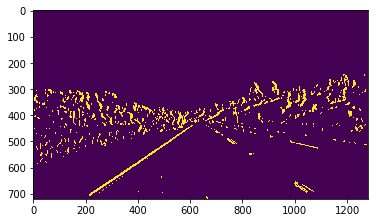

Y


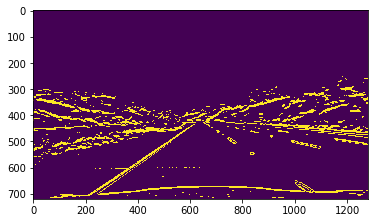

X


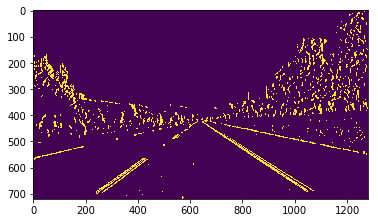

Y


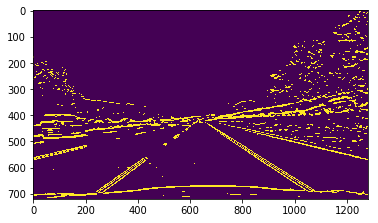

X


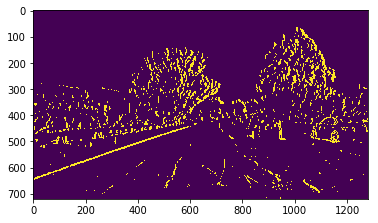

Y


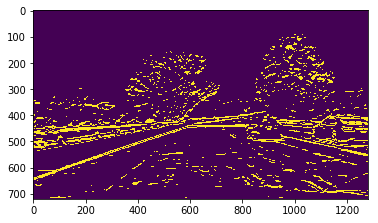

X


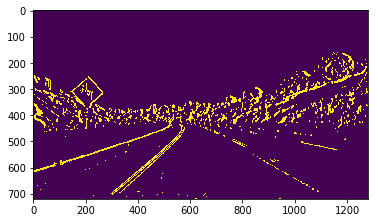

Y


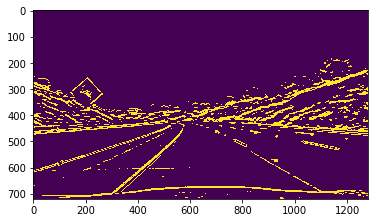

X


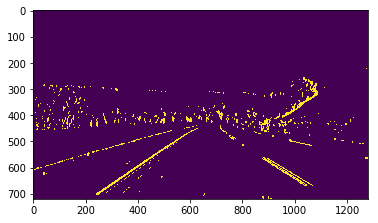

Y


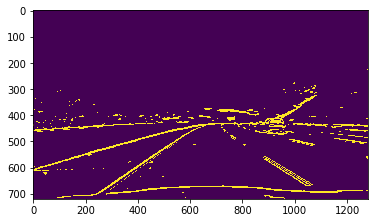

X


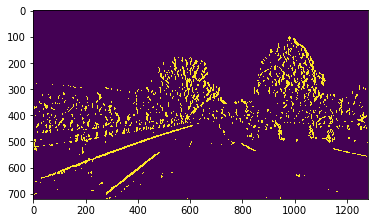

Y


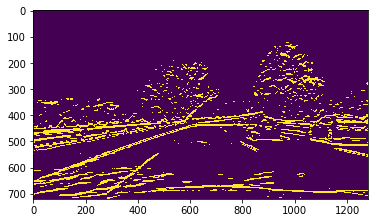

X


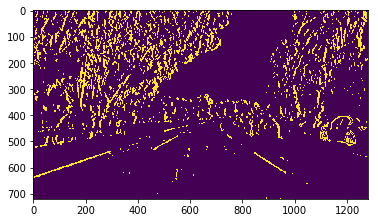

Y


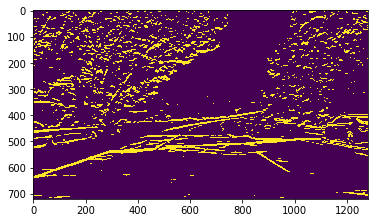

X


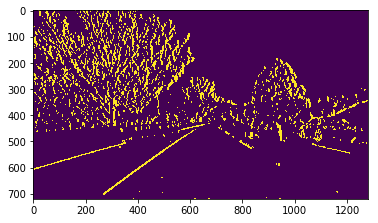

Y


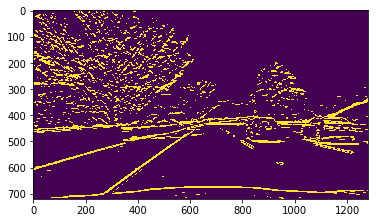

(<Figure size 5760x3600 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000286BC9E4BA8>,
       dtype=object))

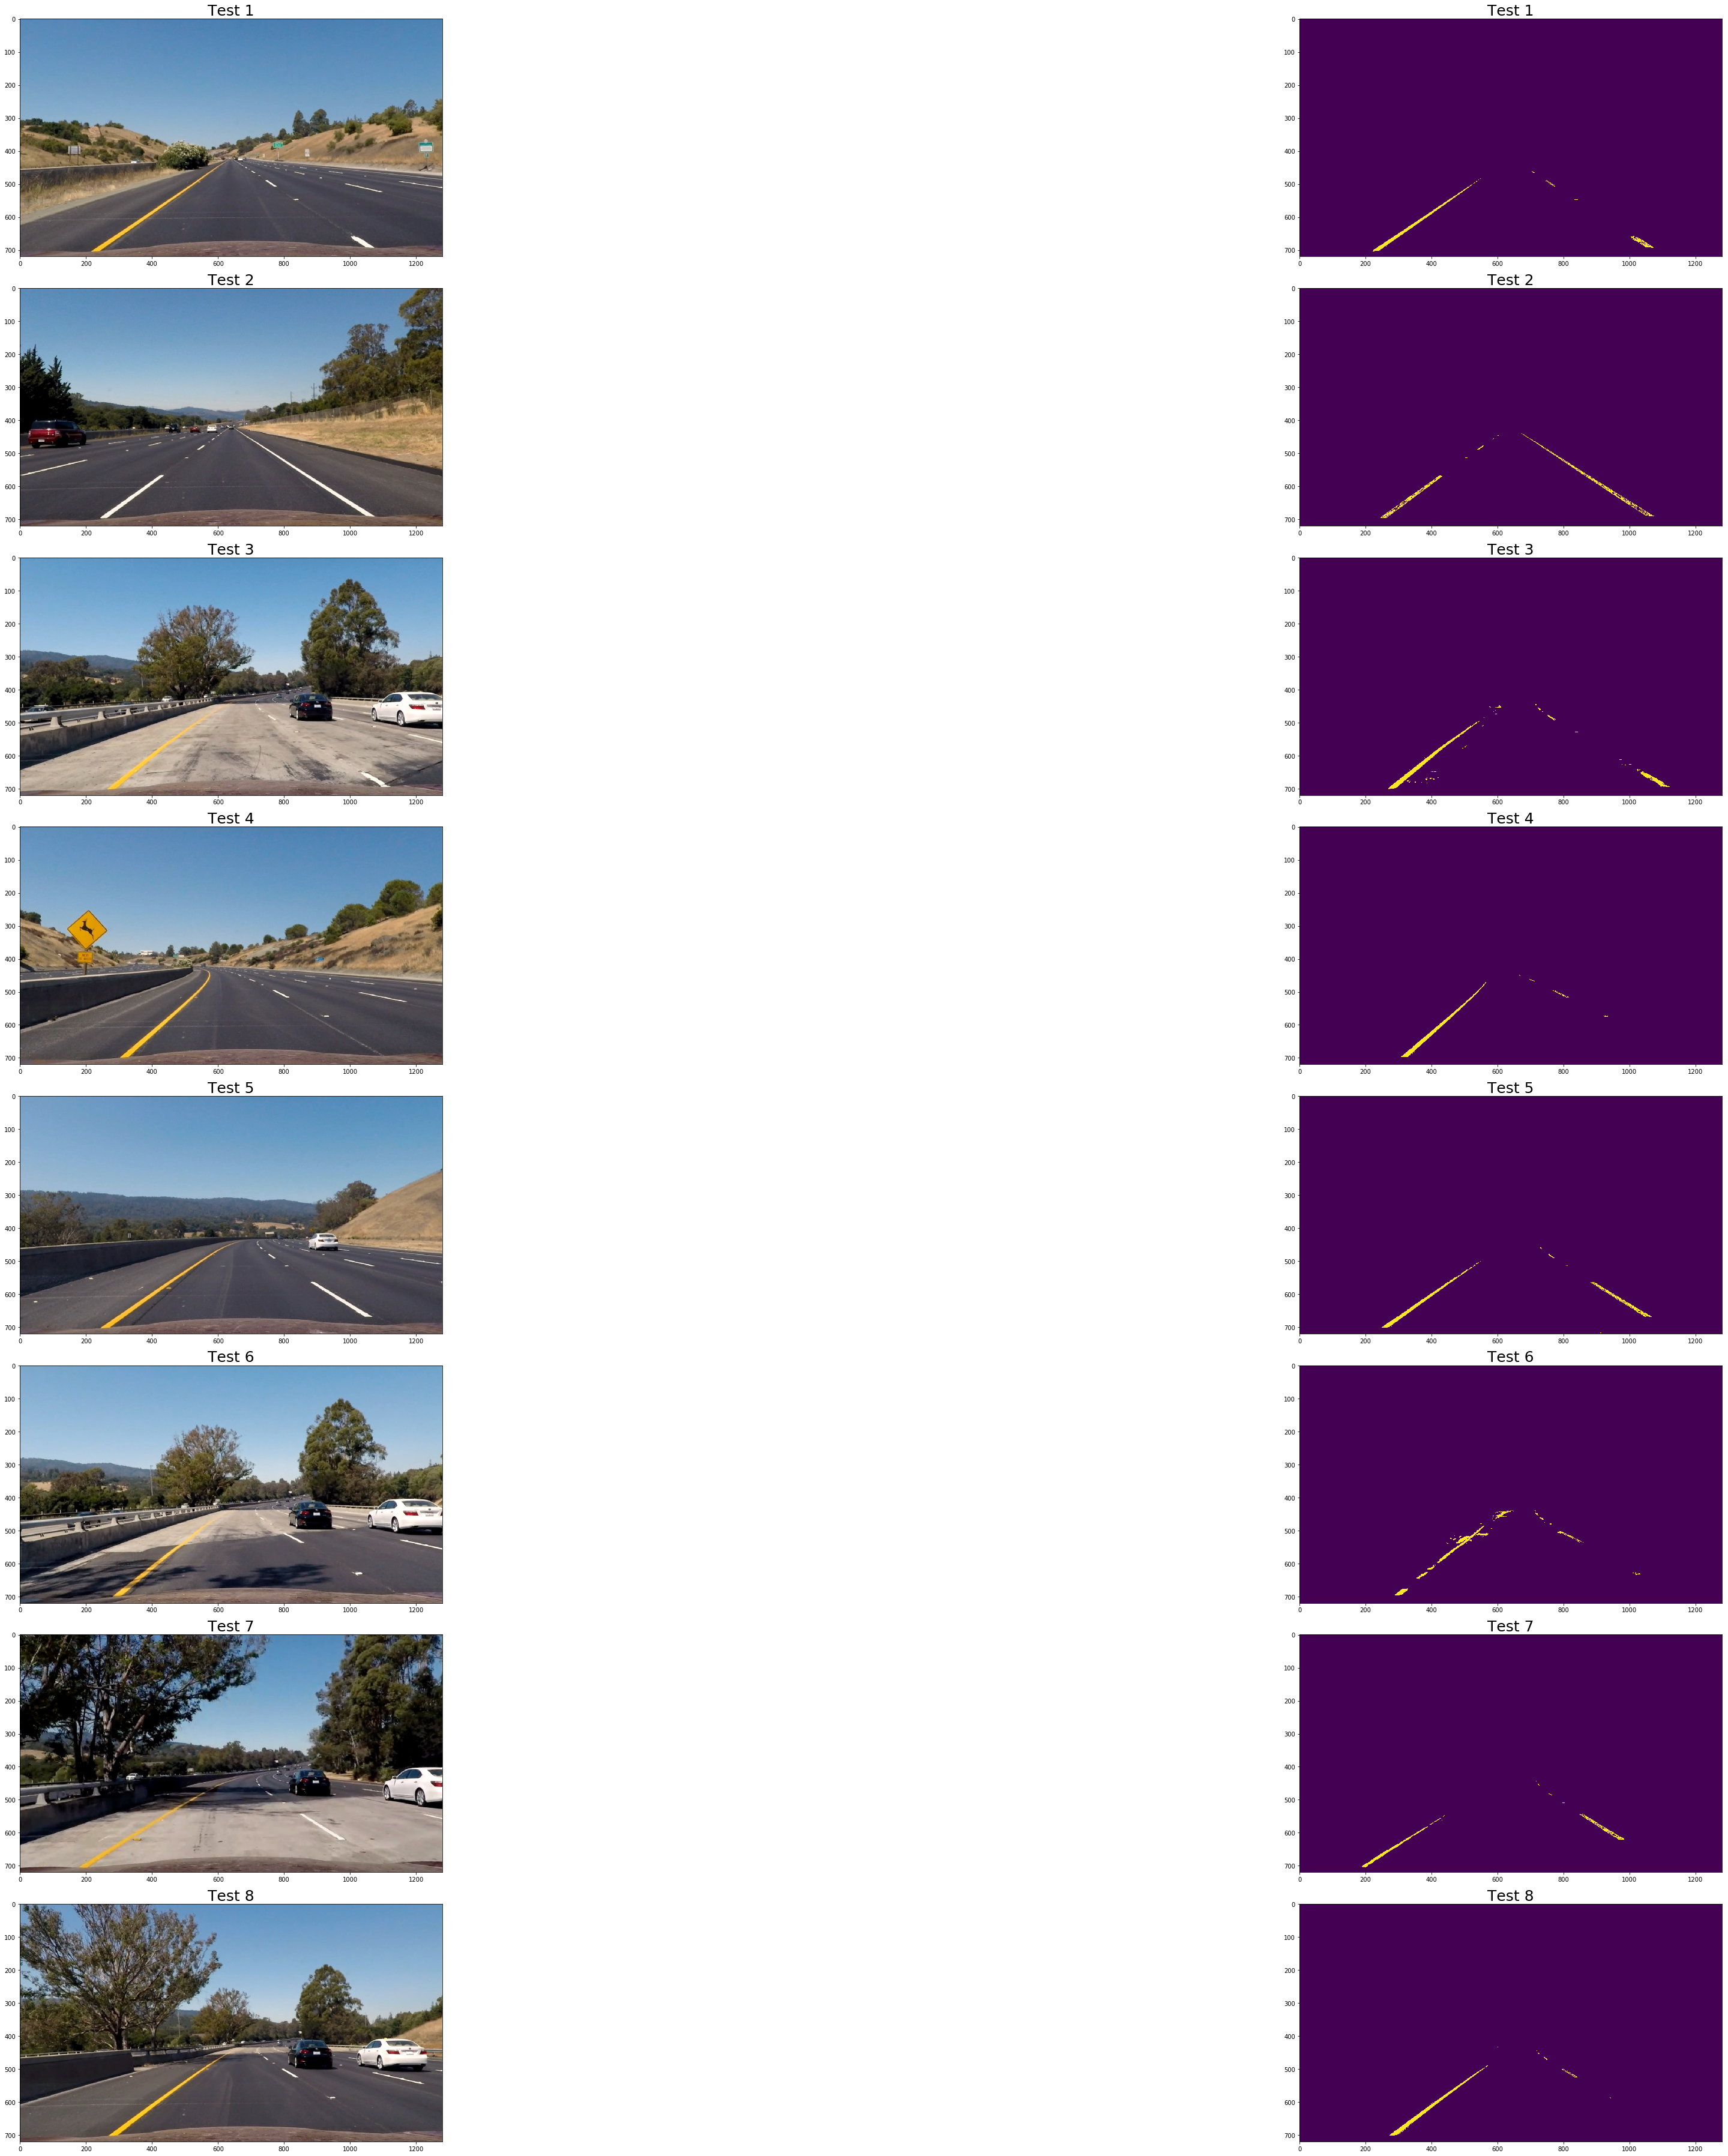

In [11]:
undist_images = []

for index in testIndexes:
    
    undist_images.append(camera.UndistortBGR(testImages[index]))

# imgObj = Image(undist)

yellow_ch1_thres = (20, 255)
yellow_ch2_thres = (30, 250)
yellow_ch3_thres = (200, 255)

white_ch1_thres = (0, 255)
white_ch2_thres = (200, 255)
white_ch3_thres = (15, 230)

yellow_thres = (yellow_ch1_thres, yellow_ch2_thres, yellow_ch3_thres)
white_thres = (white_ch1_thres, white_ch2_thres, white_ch3_thres)

regions = []

for undist_image in undist_images:
    
    if undist_image is not None:
        
        try:
            
            imgObj = Image(undist_image)
            
            yellow = imgObj.Threshold(ColorSpace=imgObj.HLS, Thres=yellow_thres, TargetChannel=2)
            white = imgObj.Threshold(ColorSpace=imgObj.HLS, Thres=white_thres, TargetChannel=2)
            
            yellow_region = imgObj.Region(yellow[1])
            white_region = imgObj.Region(white[1])
            
            combined = imgObj.Combine(yellow_region, white_region, targetChannel=0)
            
            grad_x = imgObj.Sobel(imgObj.X_DIR, 20, (20, 150))
            print("X")
            plt.imshow(grad_x)
            plt.show()
            grad_y = imgObj.Sobel(imgObj.Y_DIR, 20, (20, 150))
            print("Y")
            plt.imshow(grad_y)
            plt.show()
            
            regions.append(undist_image)
            regions.append(combined)
            
        except Exception as ex:
            
            print(ex)
            
titles = ("Test 1", "Test 1", "Test 2", "Test 2", "Test 3", "Test 3", "Test 4", "Test 4", "Test 5", "Test 5", "Test 6", "Test 6", "Test 7", "Test 7", "Test 8", "Test 8")
Plot(regions, titles, (8, 2), plotSize = (80, 50), fontSize = 25)